In [11]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


array([[1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 1]])


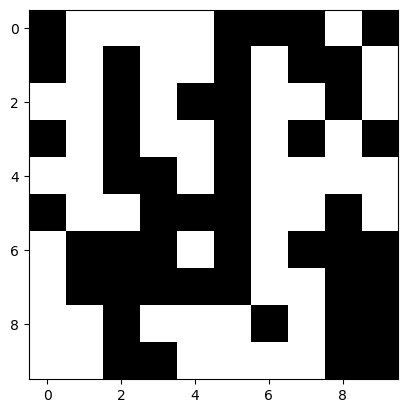

In [12]:
maze_size = (10, 10)  
maze_rand = np.random.choice([0, 1], size=maze_size)
print(repr(maze_rand))
plt.imshow(maze_rand, cmap='binary')
plt.show()

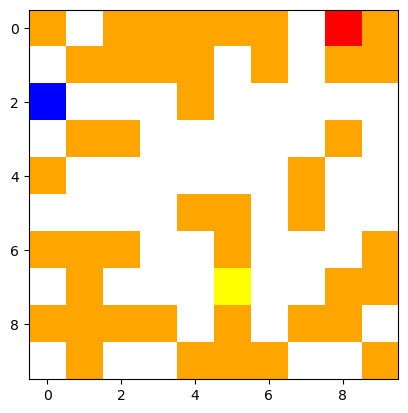

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (7, 5)]
(101, 4)
Q matrix: 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 

In [13]:
class Maze_env:
    def __init__(self , start, target, coins, maze):
        self.maze = maze
        self.target = target
        self.start = start
        self.coins = coins
        self.position = 0
        self.R = 0
        self.Q = 0
        self.states = []
        self.coin_collected = False
        self.terminate = False
        
    def plot_env(self):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[self.start] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.show()
        
    def plot_env_position(self, position, timestep):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[position] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.savefig(f'img/plot_{timestep:06d}.png', dpi=300)
        plt.show()
        plt.close() 
        
    def create_r_matrix(self):
        actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        num_states = self.maze.shape[0] * self.maze.shape[1]
        R = np.full((num_states, 4), np.nan)

        state_index = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
            # If the cell is not a wall
                if self.maze[i, j] == 0:
                    for index, action in enumerate(actions):
                        new_position = (i + action[0], j + action[1])
                        # If action leads to a valid state
                        if (0 <= new_position[0] < self.maze.shape[0] and
                            0 <= new_position[1] < self.maze.shape[1] and
                            self.maze[new_position] == 0):
                            # Calculate the state number for the new position
                            # Set reward to 0
                            R[state_index, index] = -5

                            # If action leads to goal state set reward to 100
                            if new_position == self.target:
                                R[state_index, index] = 1000
                            if new_position == self.coins:
                                R[state_index, index] = 200
                state_index += 1
                            
        self.R = R
        print(self.R.shape)
        return self.R
    
    def reward(self, state, action):
        state = self.states[state]
        x, y = state
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1
        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return -1  # hit a wall (including edges wall?)
        elif (x, y) == self.target:
            print("TRALALAAAAAAAAAAAAAAAAAAAAAA!")
            print((x,y))
            return 1 + int(self.coin_collected == True) # reached the target and bonus if collected coin
        elif (x, y) == self.coins and not self.coin_collected:
            print("DING DING DOOOOOOOOOOONG")
            return 10
        else:
            return -0.001  # regular step
        
    def transition(self, state, action):
        state_new = self.states[state]
        x, y = state_new
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            self.terminate = True
            return self.states.index(state_new)  # hit a wall, stay in the same state
        else:
            if (x, y) == self.coins and not self.coin_collected:
                self.coin_collected = True
                return 100 #specific index for coin
            else:
                if (x, y) == self.target:
                    self.terminate = True
                return self.states.index((x,y))  # move to the new state
        
    def done(self):
        return self.terminate
    
    def create_q_matrix(self):
        coord_to_index = []
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                coord_to_index.append((i,j))
        coord_to_index.append(self.coins)
        print(coord_to_index)
                
        num_states = self.maze.shape[0] * self.maze.shape[1] + 1
        num_actions = 4
        self.Q = np.zeros((num_states, num_actions))
        print(self.Q.shape)
        self.states = coord_to_index
        return self.Q, coord_to_index

maze = np.array([
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
                ])
# env = Maze_env((2,0),(0,8),(6,6), maze) 
env = Maze_env((2,0),(0,8),(7,5), maze) 
env.plot_env()
# R = env.create_r_matrix()
# print('R matrix: \n\n{}'.format(R))
Q, coord_to_index = env.create_q_matrix()
print('Q matrix: \n\n{}'.format(Q))




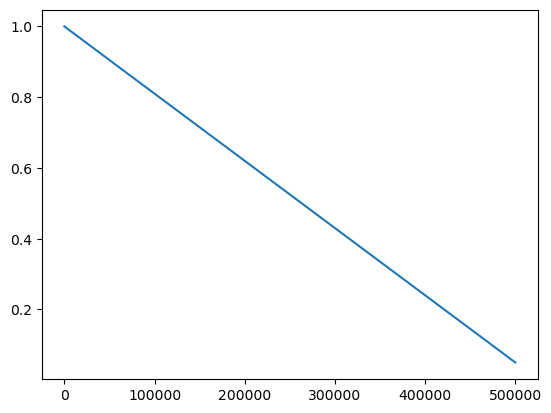

In [14]:
def plot_epsilon_decay(episodes, decay):
    max_episodes = episodes
    decay_limit = decay
    epsilon = 1
    epsilon_values = []
    for episode in range(max_episodes):
        epsilon = np.interp(episode, [0, max_episodes], [1, decay_limit])
        epsilon_values.append(epsilon)
    plt.plot(epsilon_values)
    plt.show()
    
plot_epsilon_decay(500000, 0.05)

    

In [17]:
class Q_learning:
    
    def __init__(self, alpha, gamma, epsilon, episodes, steps, env, states):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = 150.0
        self.states = states

#         self.R = env.R
#         self.R_mod = self.R.copy()
        self.Q = env.Q
        self.episodes = episodes
        self.steps = steps
        self.start = env.start
        self.target = self.states.index(env.target)
        self.coins = env.coins
        self.env = env
        self.episodes_rewards = []
        self.max_list_size = 10
        self.list_rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.threshold = 2
        self.window_size = 4
        self.current_average = 0
        
        print("Initial Q matrix is '{}'".format(self.Q))

    def plot_rewards(self):
        plt.plot(self.episodes_rewards)
        plt.show()
        
    def show_Q_spec(self,coord):
        print(q_learning.Q[self.states.index(coord)])
        
    def greedy_policy(self, state):
#                 available_actions = np.where(~np.isnan(self.R_mod[s]))[0]
#                 q_values = [self.Q[s,a] for a in available_actions]
#                 best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
        
        available_actions = np.array([0,1,2,3])
        q_values = [self.Q[state,a] for a in available_actions]
        best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]

        if np.random.uniform() < self.epsilon:
            a = np.random.choice(4)
#                     a = np.random.choice(available_actions)
        else:
#                     a = np.argmax(self.Q[s,:])
            a = np.random.choice(best_actions)
        return a
    
    def softmax_policy(self, state, temperature = 1.0):
        available_actions = np.array([0,1,2,3])
        q_values = np.array([self.Q[state,a] for a in available_actions])
        max_q_value = np.max(q_values)
        exp_values = np.exp((q_values - max_q_value) / temperature)
        action_probs = exp_values / np.sum(exp_values)

        # Sample an action based on the probabilities
        selected_action = np.random.choice(len(action_probs), p=action_probs)
        return selected_action
        
    def train(self):
        print(self.states)
#         print("Starting taget is '{}'".format(self.target))
        for episode in range(self.episodes):
            s = self.states.index(self.start)
#             print("Starting state is '{}'".format(s))
            episode_reward = 0
            env.coin_collected = False
            env.terminate = False
#             self.R_mod = self.R
            for timestep in range(self.steps):

                # Epsilon-greedy action choice
                a = self.greedy_policy(s)
#                 a = self.softmax_policy(s, self.temperature)

                # Environment updating
                r = env.reward(s, a)
#                 r = self.R_mod[s,a]
                episode_reward += r
                new_s = env.transition(s, a)
                # Doubts coordinates to Q system?
                # Q value updating
#                 print(new_s)
                self.Q[s,a] = self.Q[s,a] + self.alpha * ( r + self.gamma * np.max(self.Q[new_s,:]) - self.Q[s,a])

                if env.done():
                    break
                s = new_s
            
            self.episodes_rewards.append(episode_reward)
            
            self.list_rewards.append(episode_reward)
            if len(self.list_rewards) > self.max_list_size:
                self.list_rewards.pop(0)
            window = self.list_rewards[-self.window_size:]
            window_average = sum(window) / self.window_size
#             if abs(self.current_average - window_average) < self.threshold:
#                 print(f"Average exceeded threshold at episode {episode}. STOPPING!")
#                 break 
            self.current_average = window_average

            if episode % 100 == 0:
                print('Episode {} finished. Episode Reward {}. Timesteps {}. Average {}'.format(episode,episode_reward,timestep, window_average))
#             if episode > 5000 and episode < 200000:
#                 self.epsilon = max(self.epsilon*0.9999,0.5)
# #                 self.temperature = max(self.temperature*0.995,0.01)
#             if episode > 200000:
#                 self.epsilon = max(self.epsilon*0.9999,0.05)
#             print(self.epsilon)
            self.epsilon = np.interp(episode, [0, self.episodes], [1, 0.05])


            
    def create_video(self):
        image_folder = 'img'  # Directory containing your saved plot images
        video_name = 'video_agent.mp4'

        images = [img for img in os.listdir(image_folder) if img.endswith((".jpg", ".jpeg", ".png"))]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
    
    def test(self, limit):
        s = self.states.index(self.start)
        print("Starting state is '{}'".format(s))
        episode_reward = 0
        env.coin_collected = False
        env.terminate = False
        for timestep in range(limit):
            print("Step {}".format(timestep))
            self.env.plot_env_position(self.states[s], timestep)
            print(self.Q[s])
            a = np.argmax(self.Q[s])
            print(a)

            # Environment updating
            r = env.reward(s, a)
            print(r)
            episode_reward += r
            temp_new_s = env.transition(s, a)
#             new_s = self.states.index(temp_new_s)

            if env.done():
                self.env.plot_env_position(self.states[temp_new_s], timestep)
                break
            s = temp_new_s
        print('Episode Reward {}.Q matrix values:\n{}'.format(episode_reward,self.Q.round(1)))
        self.create_video()



            

In [18]:
q_learning = Q_learning(1, 0.999, 1, 400000, 200, env, coord_to_index)
q_learning.train()

Initial Q matrix is '[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00 -1.00000000e-03 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.10211153e+02  4.11213116e+02  4.10201218e+02  4.11028856e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.0000

Episode 15300 finished. Episode Reward -1. Timesteps 0. Average -1.001
Episode 15400 finished. Episode Reward -1.001. Timesteps 1. Average -1.0015
Episode 15500 finished. Episode Reward -1. Timesteps 0. Average -1.001
Episode 15600 finished. Episode Reward -1.003. Timesteps 3. Average -1.00125
Episode 15700 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
Episode 15800 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 15900 finished. Episode Reward -1.001. Timesteps 1. Average -1.00325
Episode 16000 finished. Episode Reward -1.004. Timesteps 4. Average -1.0015
Episode 16100 finished. Episode Reward -1.001. Timesteps 1. Average -1.00225
Episode 16200 finished. Episode Reward -1.003. Timesteps 3. Average -1.002
Episode 16300 finished. Episode Reward -1.003. Timesteps 3. Average -1.00325
Episode 16400 finished. Episode Reward -1.001. Timesteps 1. Average -1.0005
Episode 16500 finished. Episode Reward -1.002. Timesteps 2. Average -1.00075
Episode 16600 fini

Episode 27100 finished. Episode Reward -1. Timesteps 0. Average -1.001
Episode 27200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0005
Episode 27300 finished. Episode Reward -1.001. Timesteps 1. Average -1.004
Episode 27400 finished. Episode Reward -1.002. Timesteps 2. Average -1.00125
Episode 27500 finished. Episode Reward -1. Timesteps 0. Average -1.0005
Episode 27600 finished. Episode Reward -1.004. Timesteps 4. Average -1.00125
Episode 27700 finished. Episode Reward -1.001. Timesteps 1. Average -1.003
Episode 27800 finished. Episode Reward -1.001. Timesteps 1. Average -1.00075
Episode 27900 finished. Episode Reward -1. Timesteps 0. Average -1.00075
Episode 28000 finished. Episode Reward -1.001. Timesteps 1. Average -1.00075
Episode 28100 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 28200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0012499999999998
Episode 28300 finished. Episode Reward -1.003. Timesteps 3. Average -1.0035
Episode 284

Episode 56900 finished. Episode Reward -1. Timesteps 0. Average -1.002
Episode 57000 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 57100 finished. Episode Reward -1. Timesteps 0. Average -1.001
Episode 57200 finished. Episode Reward -1.001. Timesteps 1. Average -1.00075
Episode 57300 finished. Episode Reward -1.002. Timesteps 2. Average -1.001
Episode 57400 finished. Episode Reward -1.001. Timesteps 1. Average -1.00225
Episode 57500 finished. Episode Reward -1.001. Timesteps 1. Average -1.0025
Episode 57600 finished. Episode Reward -1.001. Timesteps 1. Average -1.00125
Episode 57700 finished. Episode Reward -1.001. Timesteps 1. Average -1.0034999999999998
Episode 57800 finished. Episode Reward -1.002. Timesteps 2. Average -1.0022499999999999
Episode 57900 finished. Episode Reward -1.002. Timesteps 2. Average -1.00125
Episode 58000 finished. Episode Reward -1.002. Timesteps 2. Average -1.001
Episode 58100 finished. Episode Reward -1.003. Timesteps 3. Average -1.00

Episode 86500 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 86600 finished. Episode Reward -1.004. Timesteps 4. Average -1.0027499999999998
Episode 86700 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
Episode 86800 finished. Episode Reward -1.007. Timesteps 7. Average -1.00275
Episode 86900 finished. Episode Reward -1.001. Timesteps 1. Average -1.0022499999999999
Episode 87000 finished. Episode Reward -1.001. Timesteps 1. Average -1.00125
Episode 87100 finished. Episode Reward -1.002. Timesteps 2. Average -1.00125
Episode 87200 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 87300 finished. Episode Reward -1.004. Timesteps 4. Average -1.00175
Episode 87400 finished. Episode Reward -1.001. Timesteps 1. Average -1.0015
DING DING DOOOOOOOOOOONG
Episode 87500 finished. Episode Reward -1. Timesteps 0. Average -1.0015
Episode 87600 finished. Episode Reward -1. Timesteps 0. Average -1.0015
Episode 87700 finished. Episode Reward -1.00

Episode 97400 finished. Episode Reward -1. Timesteps 0. Average -1.00075
Episode 97500 finished. Episode Reward -1.008. Timesteps 8. Average -1.00325
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 97600 finished. Episode Reward -1.001. Timesteps 1. Average -1.0022499999999999
Episode 97700 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
Episode 97800 finished. Episode Reward -1.005. Timesteps 5. Average -1.00325
Episode 97900 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 98000 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
Episode 98100 finished. Episode Reward -1.005. Timesteps 5. Average -1.0019999999999998
Episode 98200 finished. Episode Reward -1. Timesteps 0. Average -1.0012499999999998
DING DING DOOOOOOOOOOONG
Episode 98300 finished. Episode Reward -1.004. Timesteps 4. Average -1.0027499999999998
DING DING DOOOOOOOOOOONG
Episode 98400 finished. Episode Reward -1.002. Timesteps 2. Average -1.00175
DING DING DOOOOOOOO

Episode 109100 finished. Episode Reward -1.001. Timesteps 1. Average -1.0015
DING DING DOOOOOOOOOOONG
Episode 109200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0012499999999998
Episode 109300 finished. Episode Reward -1. Timesteps 0. Average -1.0014999999999998
Episode 109400 finished. Episode Reward -1.001. Timesteps 1. Average -1.001
Episode 109500 finished. Episode Reward -1. Timesteps 0. Average -1.002
Episode 109600 finished. Episode Reward -1.002. Timesteps 2. Average -1.0022499999999999
Episode 109700 finished. Episode Reward -1.004. Timesteps 4. Average -1.0019999999999998
Episode 109800 finished. Episode Reward -1. Timesteps 0. Average -1.00175
Episode 109900 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
Episode 110000 finished. Episode Reward -1.002. Timesteps 2. Average -1.00375
Episode 110100 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
DING DING DOOOOOOOOOOONG
Episode 110200 finished. Episode Reward -1.001. Timesteps 1. Aver

Episode 120900 finished. Episode Reward -1.012. Timesteps 12. Average -1.00625
Episode 121000 finished. Episode Reward -1. Timesteps 0. Average -1.0019999999999998
Episode 121100 finished. Episode Reward -1.001. Timesteps 1. Average -1.0022499999999999
Episode 121200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0012499999999998
DING DING DOOOOOOOOOOONG
Episode 121300 finished. Episode Reward -1.002. Timesteps 2. Average -1.00525
Episode 121400 finished. Episode Reward -1.001. Timesteps 1. Average -1.00075
Episode 121500 finished. Episode Reward -1.002. Timesteps 2. Average -1.00425
Episode 121600 finished. Episode Reward -1.003. Timesteps 3. Average -1.0034999999999998
Episode 121700 finished. Episode Reward -1.001. Timesteps 1. Average -1.0014999999999998
Episode 121800 finished. Episode Reward -1.002. Timesteps 2. Average -1.00125
Episode 121900 finished. Episode Reward -1.002. Timesteps 2. Average -1.001
Episode 122000 finished. Episode Reward -1.003. Timesteps 3. Averag

DING DING DOOOOOOOOOOONG
Episode 157800 finished. Episode Reward -1.001. Timesteps 1. Average -1.0022499999999999
Episode 157900 finished. Episode Reward -1. Timesteps 0. Average -1.001
Episode 158000 finished. Episode Reward -1.004. Timesteps 4. Average -1.004
DING DING DOOOOOOOOOOONG
Episode 158100 finished. Episode Reward -1.001. Timesteps 1. Average -1.0002499999999999
Episode 158200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0012499999999998
Episode 158300 finished. Episode Reward -1.004. Timesteps 4. Average -1.0015
Episode 158400 finished. Episode Reward -1.002. Timesteps 2. Average -1.0022499999999999
Episode 158500 finished. Episode Reward -1.007. Timesteps 7. Average -1.004
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 158600 finished. Episode Reward -1.003. Timesteps 3. Average -1.0022499999999999
Episode 158700 finished. Episode Reward -1.005. Timesteps 5. Average -1.0062499999999999
Episode 158800 finished. Episode Reward -1.001. Timesteps 1. Aver

Episode 180200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0025
Episode 180300 finished. Episode Reward -1.001. Timesteps 1. Average -1.0025
Episode 180400 finished. Episode Reward -1. Timesteps 0. Average -1.0015
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 180500 finished. Episode Reward -1.003. Timesteps 3. Average -1.00375
Episode 180600 finished. Episode Reward -1.001. Timesteps 1. Average -1.0025
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 180700 finished. Episode Reward -1.001. Timesteps 1. Average -1.004
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 180800 finished. Episode Reward -1.001. Timesteps 1. Average -1.002
DING DING DOOOOOOOOOOONG
Episode 180900 finished. Episode Reward -0.017000000000000015. Timesteps 18. Average -0.7559999999999999
DING DING DOOOOOOOOOOONG
Episode 181000 finished. Episode Reward -1.006. Timesteps 6. Average -1.0022499999999999
Episode 181100 finished. Episode Reward -1.002.

DING DING DOOOOOOOOOOONG
Episode 221800 finished. Episode Reward -1.001. Timesteps 1. Average -1.008
Episode 221900 finished. Episode Reward -1.001. Timesteps 1. Average -1.0025
DING DING DOOOOOOOOOOONG
Episode 222000 finished. Episode Reward -1.001. Timesteps 1. Average -1.005
Episode 222100 finished. Episode Reward -1.009. Timesteps 9. Average -1.0042499999999999
Episode 222200 finished. Episode Reward -1.003. Timesteps 3. Average -1.001
DING DING DOOOOOOOOOOONG
Episode 222300 finished. Episode Reward -1.001. Timesteps 1. Average -1.0042499999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 222400 finished. Episode Reward -1.009. Timesteps 9. Average -1.0074999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 222500 finished. Episode Reward -1.001. Timesteps 1. Average -1.00575
DING DING DOOOOOOOOOOONG
Episode 222600 finished. Episode Reward -1.002. Timesteps 2. Average -1.0025
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOON

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 251100 finished. Episode Reward -1.007. Timesteps 7. Average -1.004
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 251200 finished. Episode Reward -0.02100000000000002. Timesteps 22. Average -0.758
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 251300 finished. Episode Reward -1.011. Timesteps 11. Average -1.0114999999999998
DING DING DOOOOOOOOOOONG
Episode 251400 finished. Episode Reward -1. Timesteps 0. Average -1.005
Episode 251500 finished. Episode Reward -1.01. Timesteps 10. Average -1.003
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 251600 finished. Episode Reward -1.003. Timesteps 3. Average -1.0037500000000001
DING DING DOOOOOOOOOOONG
Episod

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 259700 finished. Episode Reward -1.001. Timesteps 1. Average -1.0015
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 259800 finished. Episode Reward -1.011. Timesteps 11. Average -1.0045
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 259900 finished. Episode Reward -1.002. Timesteps 2. Average -1.0095
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 260000 finished. Episode Reward -1.001. Timesteps 1. Average -1.00175
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 260100 finished. Episode Reward -1.003. Timesteps 3. Average -1.00475
DING DING DOOOOOOOOOOONG
DING DING DO

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 269900 finished. Episode Reward -1.003. Timesteps 3. Average -1.00525
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 270000 finished. Episode Reward -1.009. Timesteps 9. Average -1.004
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 270100 finished. Episode Reward -1.001. Timesteps 1. Average -1.00475
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 270200 finished. Episode Reward -1.001. Timesteps 1. Average -1.0042499999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING

DING DING DOOOOOOOOOOONG
Episode 288500 finished. Episode Reward -1.015. Timesteps 15. Average -1.0059999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 288600 finished. Episode Reward -1.007. Timesteps 7. Average -1.006
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 288700 finished. Episode Reward -1.009. Timesteps 9. Average -1.00525
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING D

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 295300 finished. Episode Reward -0.027000000000000024. Timesteps 28. Average -0.51325
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 295400 finished. Episode Reward -1.004. Timesteps 4. Average -1.0074999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 295500 finished. Episode Reward -1.007. Timesteps 7. Average -1.00325
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOO

DING DING DOOOOOOOOOOONG
Episode 300200 finished. Episode Reward -1.006. Timesteps 6. Average -1.00375
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 300300 finished. Episode Reward -1.004. Timesteps 4. Average -1.0034999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 300400 finished. Episode Reward -1. Timesteps 0. Average -1.0070000000000001
DING DING DOOOOOOOOOOONG
Episode 300500 finished. Episode Reward -1.021. Timesteps 21. Average -0.7625
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 300600 finished. Episode Reward -1.00

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 315400 finished. Episode Reward -1. Timesteps 0. Average -0.75675
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 315500 finished. Episode Reward -1.003. Timesteps 3. Average -1.0105
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 315600 finished. Episode Reward -0.03300000000000003. Timesteps 34. Average -0.7637499999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 315700 finished. Episode Reward -1.001. Timesteps 1. Average -1.0034999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING D

DING DING DOOOOOOOOOOONG
Episode 320900 finished. Episode Reward -1.005. Timesteps 5. Average -1.00325
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 321000 finished. Episode Reward -1.002. Timesteps 2. Average -1.002
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 321100 finished. Episode Reward -1.009. Timesteps 9. Average -0.759
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 321200 finished. Episode Reward -1.006. Timesteps 6. Average -1.004
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DI

Episode 327000 finished. Episode Reward -1.02. Timesteps 20. Average -1.0084999999999997
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 327100 finished. Episode Reward -1.015. Timesteps 15. Average -0.766
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 327200 finished. Episode Reward -1.001. Timesteps 1. Average -1.00775
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 327300 finished. Episode Reward -1. Timesteps 0. Average -1.0030000000000001
Episode 327400 finished. Episode Reward -1.001. Timesteps 1. Average -1.005
Episode 327500 finished. Episode Reward -1.029. Timesteps 29. Average -1.00875
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOO

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 334400 finished. Episode Reward -0.017000000000000015. Timesteps 18. Average -0.51025
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 334500 finished. Episode Reward -1.001. Timesteps 1. Average -1.00225
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 334600 finished. Episode Reward -1.002. Timesteps 2. Average -1.0042499999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 334700 finished. Episode Reward -1.024. Timesteps 24. Average -1.01425
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING 

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 339200 finished. Episode Reward -1.018. Timesteps 18. Average -1.0065
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 339300 finished. Episode Reward -1.014. Timesteps 14. Average -1.0085
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 339400 finished. Episode Reward -0.025000000000000022. Timesteps 26. Average -0.7619999999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 339500 finished. Episode Reward -1. Timesteps 0. Average -1.00125
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 339600 finished. Episode Reward -1.003. Timesteps 3. Aver

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 347500 finished. Episode Reward -1.002. Timesteps 2. Average -0.75875
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 347600 finished. Episode Reward -0.01100000000000001. Timesteps 12. Average -0.50775
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING

DING DING DOOOOOOOOOOONG
Episode 353600 finished. Episode Reward -1.003. Timesteps 3. Average -1.0025
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 353700 finished. Episode Reward -0.02100000000000002. Timesteps 22. Average -0.7585
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 353800 finished. Episode Reward -1.004. Timesteps 4. Average -0.75975
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DIN

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 360800 finished. Episode Reward -1.003. Timesteps 3. Average -0.7609999999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 360900 finished. Episode Reward -1.003. Timesteps 3. Average -0.7595000000000001
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 361000 finished. Episode Re

Episode 389400 finished. Episode Reward -1.003. Timesteps 3. Average -1.0122499999999999
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 389500 finished. Episode Reward -1.008. Timesteps 8. Average -1.00725
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DIN

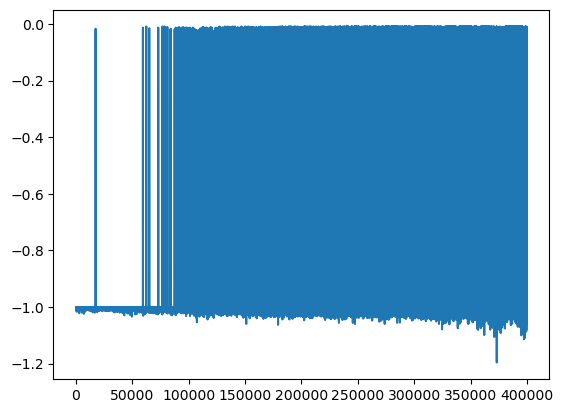

In [19]:
q_learning.plot_rewards()

Starting state is '20'
Step 0


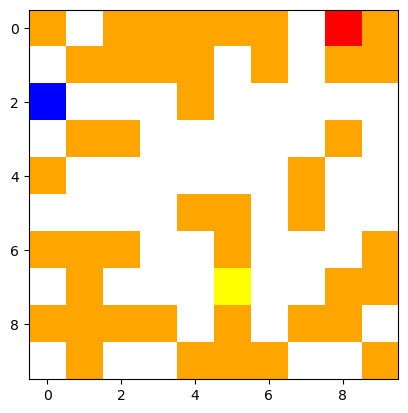

[254.58971067 254.30337029 253.95659217 255.21180397]
3
-0.001
Step 1


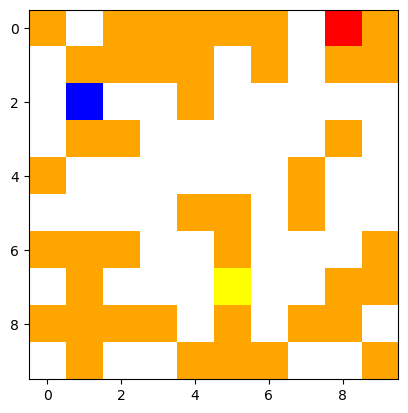

[254.21280397 254.21280397 246.73637013 255.46827224]
3
-0.001
Step 2


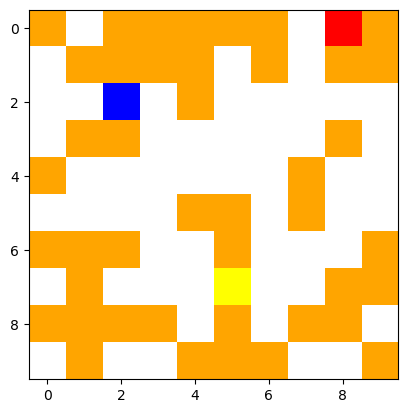

[254.3580179  254.3580179  255.21180397 255.72499724]
3
-0.001
Step 3


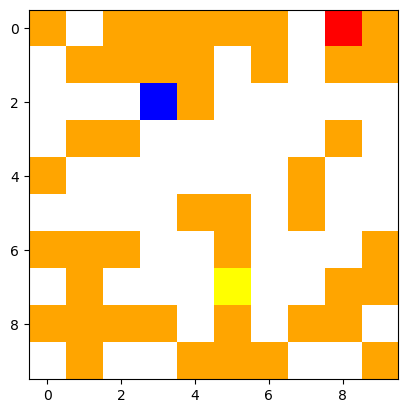

[254.72599724 255.98197922 255.46827224 254.72599724]
1
-0.001
Step 4


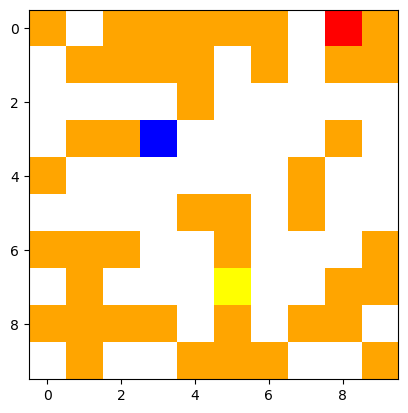

[255.32714192 256.23921844 246.72895116 256.23921844]
1
-0.001
Step 5


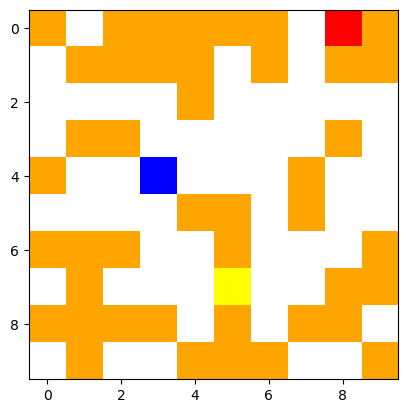

[247.68521534 247.76901557 247.50740688 256.49671515]
3
-0.001
Step 6


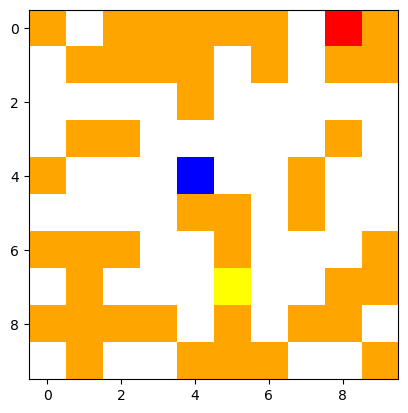

[256.23921844 255.49771515 256.7485105  256.75446962]
3
-0.001
Step 7


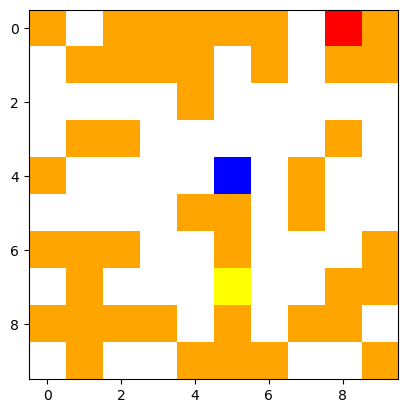

[256.09766388 255.75546962 256.75148559 257.01248211]
3
-0.001
Step 8


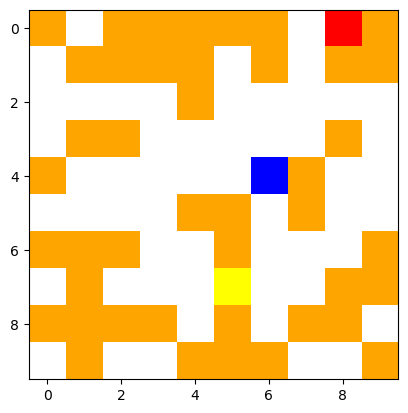

[255.84056622 257.27075286 257.00949508 255.61363153]
1
-0.001
Step 9


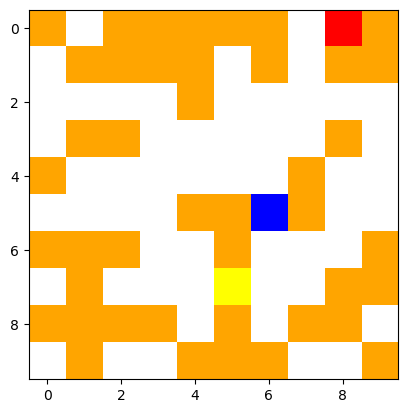

[256.61263153 257.52928214 256.27175286 256.27175286]
1
-0.001
Step 10


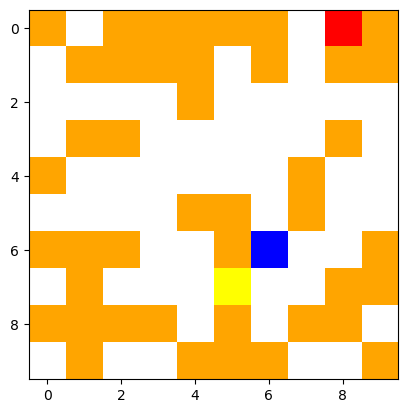

[257.16573064 257.78807021 256.4261538  257.27075286]
1
-0.001
Step 11


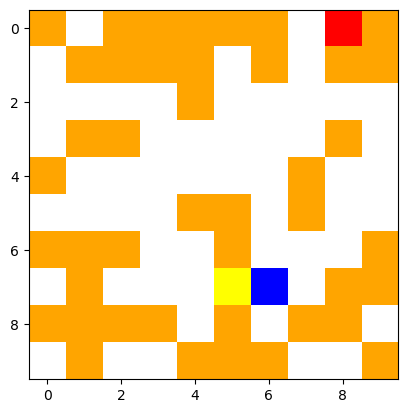

[257.52928214 257.52928214 258.04711733 257.52928214]
2
DING DING DOOOOOOOOOOONG
1
Step 12


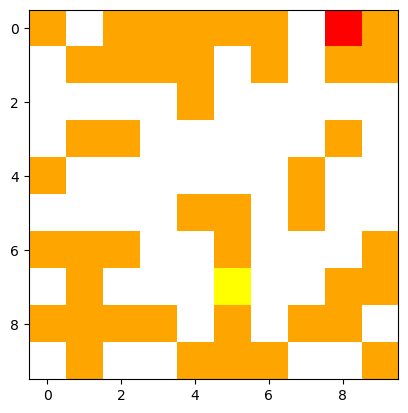

[257.30442175 257.30442175 256.87050203 247.351701  ]
0
-1


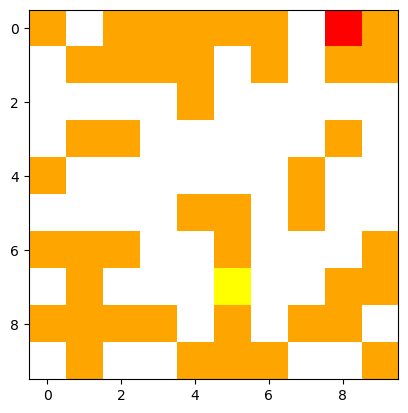

Episode Reward -0.01100000000000001.Q matrix values:
[[  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [213.5 214.6 213.5   0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [246.4 254.6 245.9 246. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [213.5 213.8 212.8 213.4]
 [  0.    0.    0.    0. ]
 [214.5 214.3 214.5 214. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [254.6 254.3 254.  255.2]
 [254.2 254.2 246.7 255.5]
 [254.4 254.4 255.2 255.7]
 [254.7 256.  255.5 254.7]
 [  0.    0.    0.    0. ]
 [213.8 214.  212.8 214. ]
 [213.6 213.9 214.  214.1]
 [214.3 214.2 214.3 214.3]
 [214.2 213.3 214.5 214.4]
 [213.4 214.6 214.6 213.9]
 [255.7 246.1 245.7 246.8]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [255.3 256.2 246.7 256.2]
 [255.2 256.5 248.  256.5]
 [

In [20]:
q_learning.test(50)

In [ ]:
q_learning.show_Q_spec((5,6))
q_learning.show_Q_spec((3,5))
q_learning.show_Q_spec((4,5))

In [ ]:
7
